### Copyright (C) Infineon Technologies AG 2025
 
Copyright (c) 2025, Infineon Technologies AG, or an affiliate of Infineon Technologies AG. All rights reserved.
This software, associated documentation and materials ("Software") is owned by Infineon Technologies AG or one of its affiliates ("Infineon") and is protected by and subject to worldwide patent protection, worldwide copyright laws, and international treaty provisions. Therefore, you may use this Software only as provided in the license agreement accompanying the software package from which you obtained this Software. If no license agreement applies, then any use, reproduction, modification, translation, or compilation of this Software is prohibited without the express written permission of Infineon.

Disclaimer: UNLESS OTHERWISE EXPRESSLY AGREED WITH INFINEON, THIS SOFTWARE IS PROVIDED AS-IS, WITH NO WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ALL WARRANTIES OF NON-INFRINGEMENT OF THIRD-PARTY RIGHTS AND IMPLIED WARRANTIES SUCH AS WARRANTIES OF FITNESS FOR A SPECIFIC USE/PURPOSE OR MERCHANTABILITY. Infineon reserves the right to make changes to the Software without notice. You are responsible for properly designing, programming, and testing the functionality and safety of your intended application of the Software, as well as complying with any legal requirements related to its use. Infineon does not guarantee that the Software will be free from intrusion, data theft or loss, or other breaches ("Security Breaches"), and Infineon shall have no liability arising out of any Security Breaches. Unless otherwise explicitly approved by Infineon, the Software may not be used in any application where a failure of the Product or any consequences of the use thereof can reasonably be expected to result in personal injury.

### Model Template

This is a template for adding a new model that is already trained and ready for inference. Please run this first (to make sure everything works on your machine) and then navigate through the TO DOs to add your model and data step by step. 

In [1]:
# TO DO: remove libs you don't need and add libs you need

import sys
import os

# Add the parent directory to the Python path so we can import from CentralScripts
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import CentralScripts.helper_functions as cs

#### Adding a Model

The purpose of the model is to demonstrate compilation for AURIX&trade;. You are invited to replace this with your model.

In [2]:
from modelling_helper import get_model

# TO DO: add your model in modelling helper
origin = "tf"  # choose your origin, e.g., "tf" for TensorFlow, "torch" for PyTorch

# TO DO: choose your model_name
model_name = "new_model"

# TO DO: add your model
model = get_model(origin)

/home/wsluser/git/ai-model-zoo-productive/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Adding Input Data

You could use random input data or import your input data here and convert it into a numpy array.
We will run inference on it to generate the predictions.

In [3]:
import numpy as np

# TO DO: add an exemplary input as numpy array
input_target = np.random.rand(10).astype(np.float32)  # Example input for the model
output_target = cs.get_predictions(origin, model, input_target)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


#### Export and Save Model and Data

We now export model, input, and output data: 
- the model will be converted into ONNX
- input, and output will be stored as .pb.

In [4]:
# export model and data as ONNX and .pb
cs.save_all(model_name, input_target, output_target, model, origin)
cs.test_onnx_pb(model_name)

Directory already exists: out/new_model/test_new_model
Output matches expected output within tolerance.


#### Compiling the Model for AURIX&trade;

All the tools we need are included in a docker container. We fetch / start the Docker container next.

In [5]:
# Check if the docker container is running. If not, fetch and/ or start it.
cs.ensure_docker_container()

Docker container 'unruffled_galois' (from image 'aurix_ai_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


We now generate a C file from the ONNX and convert this into an elf file next. The elf file is executed using the open-source hardware emulator QEMU to estimate the execution. 

In [6]:
from CentralScripts.python_flask_client import CallTools

model_folder, onnx_model_file = cs.get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/new_model/test_new_model/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/new_model/test_new_model/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


#### Analysis of Execution Timing

- For each node in the neural network the number of clock cycles is extracted from the log file and plotted.
- You can inspect which node is a computational bottleneck and adjust your network.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


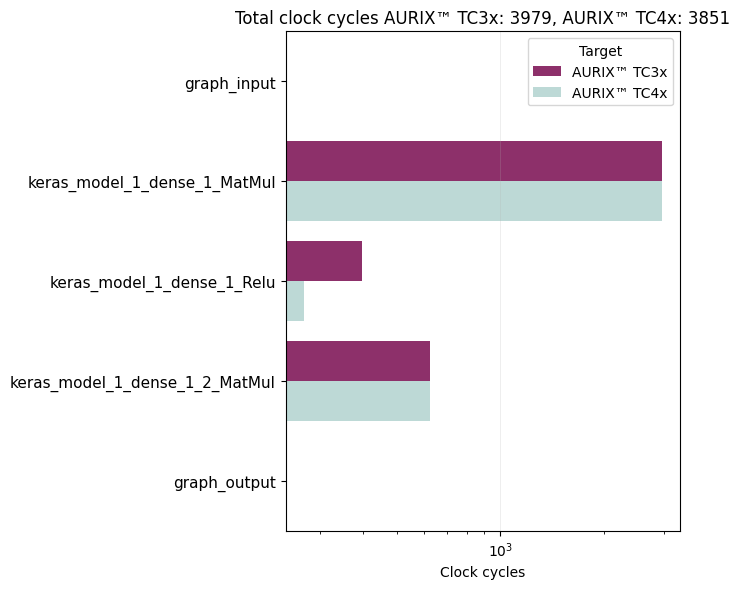

In [7]:
cs.plot_execution_timing(model_name)

#### Congrats on Compiling your Model. 
If you got here without any error, it looks like you made it.